In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
sns.set_style("darkgrid")
sns.set_context("notebook")
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["dir", "/b", "/a-d","input"], shell=True).decode("utf8"))

# Any results you write to the current directory are saved as output.

Set some constants we need to compute Elo ratings

In [2]:
mean_elo = 1500
elo_width = 400
k_factor = 64

## Load the data ##

In [3]:
data_dir = 'input/'

In [4]:
df_reg = pd.read_csv(data_dir + 'RegularSeasonCompactResults_Prelim2018.csv')
df_tour = pd.read_csv(data_dir + 'NCAATourneyCompactResults.csv')
df_tour_b2017 = df_tour[df_tour.Season < 2017]
df_tour_test = df_tour[df_tour.Season > 2016]

- Concatenate both regular season and tournament results into one DataFrame.
- Drop the columns we don't need. 
- Sort chronologically, ie by season, then by date in that season

In [5]:
#df_concat = pd.concat((df_reg, df_tour_b2017), ignore_index=True)  #uncomment this line to run test data

df_concat = pd.concat((df_reg, df_tour), ignore_index=True) #uncomment this line to run full data

#renaming columns to match script cuz I'm lazy
df_concat.rename(columns={'DayNum': 'Daynum', 'WTeamID': 'Wteam', 'LTeamID': 'Lteam'}, inplace=True)
df_concat.drop(labels=[ 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
df_concat.sort_values(by=['Season', 'Daynum'], inplace=True)
df_concat.head()

,Season,Daynum,Wteam,Lteam
0,1985,20,1228,1328
1,1985,25,1106,1354
2,1985,25,1112,1223
3,1985,25,1165,1432
4,1985,25,1192,1447


Transform team IDs to be from 0 to number_of_teams-1.
We do this so that we can use team ID as an index for lookups later.

In [6]:
le = LabelEncoder()
df_concat.Wteam = le.fit_transform(df_concat.Wteam)
df_concat.Lteam = le.fit_transform(df_concat.Lteam)

### Prep Test Data Set

Uncomment this section to run test data

In [7]:
# df_tour_test.rename(columns={'DayNum': 'Daynum', 'WTeamID': 'Wteam', 'LTeamID': 'Lteam'}, inplace=True)
# df_tour_test.drop(labels=[ 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace=True, axis=1)
# df_tour_test.Wteam = le.transform(df_tour_test.Wteam)
# df_tour_test.Lteam = le.transform(df_tour_test.Lteam)
# df_tour_test.head()

## Elo stuff preparation ##
Define the functions we need to calculate the probability of winning given two Elo ratings,
and also the change in Elo rating after a game is played.

In [8]:
def update_elo(winner_elo, loser_elo):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expected_win = expected_result(winner_elo, loser_elo)
    change_in_elo = k_factor * (1-expected_win)
    winner_elo += change_in_elo
    loser_elo -= change_in_elo
    return winner_elo, loser_elo

def expected_result(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

In [9]:
def update_end_of_season(elos):
    """Regression towards the mean
    
    Following 538 nfl methods
    https://fivethirtyeight.com/datalab/nfl-elo-ratings-are-back/
    """
    diff_from_mean = elos - mean_elo
    elos -= diff_from_mean/3
    return elos

In [10]:
df_concat['w_elo_before_game'] = 0
df_concat['w_elo_after_game'] = 0
df_concat['l_elo_before_game'] = 0
df_concat['l_elo_after_game'] = 0
elo_per_season = {}
n_teams = len(le.classes_)
current_elos = np.ones(shape=(n_teams)) * mean_elo
print(n_teams)

364


# Make a new column with a unique time
I use days since Jan 1, 1970 to be able to convert to a datetime object later

In [11]:
df_concat['total_days'] = (df_concat.Season-1970)*365.25 + df_concat.Daynum

In [12]:
df_team_elos = pd.DataFrame(index=df_concat.total_days.unique(), 
                            columns=range(n_teams))
df_team_elos.iloc[0, :] = current_elos

## The loop where it happens ##

- We go through each row in the DataFrame. 
- We look up the current Elo rating of both teams. 
- We calculate the expected wins for the team that *actually won*. This is also what we use for *probability of winning*.
- Write Elo before and after the game in the Data Frame. 
- Update the Elo rating for both teams in the "current_elos" list.

In [13]:
current_season = df_concat.at[0, 'Season']
for row in df_concat.itertuples():
    if row.Season != current_season:
        # Check if we are starting a new season. 
        # Regress all ratings towards the mean
        current_elos = update_end_of_season(current_elos)
        # Write the beginning of new season ratings to a dict for later lookups.
        elo_per_season[row.Season] = current_elos.copy()
        current_season = row.Season
    idx = row.Index
    w_id = row.Wteam
    l_id = row.Lteam
    # Get current elos
    w_elo_before = current_elos[w_id]
    l_elo_before = current_elos[l_id]
    # Update on game results
    w_elo_after, l_elo_after = update_elo(w_elo_before, l_elo_before)
        
    # Save updated elos
    df_concat.at[idx, 'w_elo_before_game'] = w_elo_before
    df_concat.at[idx, 'l_elo_before_game'] = l_elo_before
    df_concat.at[idx, 'w_elo_after_game'] = w_elo_after
    df_concat.at[idx, 'l_elo_after_game'] = l_elo_after
    current_elos[w_id] = w_elo_after
    current_elos[l_id] = l_elo_after
    
    # Save elos to team DataFrame
    today = row.total_days
    df_team_elos.at[today, w_id] = w_elo_after
    df_team_elos.at[today, l_id] = l_elo_after


## Evaluation Model Overall
Sample 10,000 games from recent seasons. 
Record the expected wins and use this to calculate the logloss.

In [14]:
#n_samples = 10000
#samples = df_concat[df_concat.Season > 2010].sample(n_samples)
loss=0
expected_list = []
win_loss_list = []
for row in df_concat.itertuples():  #change to sample.itertuples() to run sample test uncomment first two lines
    w_elo = row.w_elo_before_game
    l_elo = row.l_elo_before_game
    w_expected = expected_result(w_elo, l_elo)
    expected_list.append(w_expected)
    win_loss_list.append(int(round(w_expected))) #this round doesn't round 0.5 up to 1 but to works pretty well
    loss += np.log(w_expected)
print(loss/len(expected_list))
print(expected_list[100:105])
print(win_loss_list[100:105])

-0.570264332725
[0.5, 0.5, 0.45122566414025822, 0.5, 0.54592192278048368]
[0, 0, 0, 0, 1]


In [15]:
numberofcorrect = win_loss_list.count(1)
print("Accuracy Score:")
print(numberofcorrect/len(win_loss_list))

Accuracy Score:
0.6949544196439907


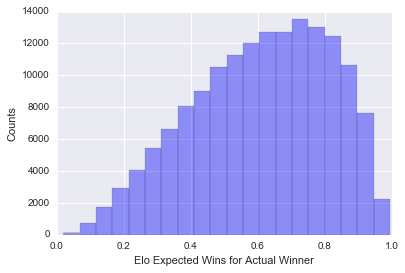

In [16]:
sns.distplot(expected_list, kde=False, bins=20)
plt.xlabel('Elo Expected Wins for Actual Winner')
plt.ylabel('Counts')

## Look at Elo ratings over time ##

- Fill all the N/As with the previous Elo rating. 
- Rename the columns to a string
- Make a new column with the datetime of the game

In [17]:
df_team_elos.fillna(method='ffill', inplace=True)
trans_dict = {i: 'team_{}'.format(i) for i in range(n_teams)}
df_team_elos.rename(columns=trans_dict, inplace=True)
epoch = (df_team_elos.index)
df_team_elos['date'] = pd.to_datetime(epoch, unit='D')
df_team_elos.head()

,team_0,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,...,team_355,team_356,team_357,team_358,team_359,team_360,team_361,team_362,team_363,date
5498.75,1500.0,1500.0,1500.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.000000,1985-01-20 18:00:00
5503.75,1500.0,1500.0,1500.0,1500.000000,1500.0,1532.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.000000,1985-01-25 18:00:00
5504.75,1500.0,1468.0,1500.0,1500.000000,1500.0,1532.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.000000,1500.0,1500.0,1500.0,1500.0,1500.0,1500.000000,1985-01-26 18:00:00
5505.75,1500.0,1468.0,1500.0,1500.000000,1500.0,1532.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1529.060997,1500.0,1500.0,1500.0,1500.0,1500.0,1500.000000,1985-01-27 18:00:00
5506.75,1500.0,1468.0,1500.0,1529.060997,1500.0,1532.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1529.060997,1500.0,1500.0,1500.0,1500.0,1500.0,1529.060997,1985-01-28 18:00:00


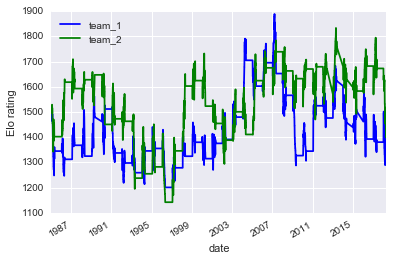

In [18]:
df_team_elos.plot(x='date', y=['team_1', 'team_2'])
plt.ylabel('Elo rating')

## Prep Test Data for Predictions

In [19]:
# #dictionary for end of season elo score (change elo_per_season value)
# trans_elo = dict(zip(range((elo_per_season[2017].shape[0])),elo_per_season[2017]))

# #map elo to test dataset
# df_tour_test["W_elo"] = df_tour_test["Wteam"].map(trans_elo)
# df_tour_test["L_elo"] = df_tour_test["Lteam"].map(trans_elo)

# #run prediction
# loss=0
# expected_list = []
# win_loss_list = []
# for row in df_tour_test.itertuples():
#     w_elo = row.W_elo
#     l_elo = row.L_elo
#     w_expected = expected_result(w_elo, l_elo)
#     expected_list.append(w_expected)
#     win_loss_list.append(int(round(w_expected))) #this round doesn't round 0.5 up
#     loss += np.log(w_expected)
# print(loss/len(expected_list))
# print(expected_list[0:5])
# print(win_loss_list[0:5])

# numberofcorrect = win_loss_list.count(1)
# print("Accuracy Score:")
# print(numberofcorrect/len(win_loss_list))

## Actual 2018 Predictions

In [20]:
df_predict = pd.read_csv(data_dir + 'SampleSubmissionStage2.csv')
df_teams = pd.read_csv(data_dir + 'Teams.csv')


def get_year_t1_t2(id):
    """Return a tuple with ints `year`, `team1` and `team2`."""
    return (int(x) for x in id.split('_'))

for row in df_predict.itertuples():
    year, t1, t2 = get_year_t1_t2(row.ID)
    idx = row.Index
    df_predict.at[idx, 'Year'] = year
    df_predict.at[idx, 'Wteam'] = t1
    df_predict.at[idx, 'Lteam'] = t2


#this is a lambda expression simlified into a function the actual lambda expression is commented out
#df_predict['WteamName'] = df_predict['Wteam'].apply(lambda team: df_teams['TeamName'][(df_teams['TeamID'] == team)].value[0])
def lookup_team(team):
    match = (df_teams['TeamID'] == team)
    team = df_teams['TeamName'][match]
    return team.values[0]    

df_predict['WteamName'] = df_predict['Wteam'].apply(lookup_team)
df_predict['LteamName'] = df_predict['Lteam'].apply(lookup_team)

#transform to indexed id
df_predict.Wteam = le.transform(df_predict.Wteam)
df_predict.Lteam = le.transform(df_predict.Lteam)

#dictionary for end of season elo score
trans_elo = dict(zip(range((elo_per_season[2018].shape[0])),elo_per_season[2018]))

#map elo to dataset
df_predict["W_elo"] = df_predict["Wteam"].map(trans_elo)
df_predict["L_elo"] = df_predict["Lteam"].map(trans_elo)

#run prediction
loss=0
expected_list = []
win_loss_list = []
for row in df_predict.itertuples():
    w_elo = row.W_elo
    l_elo = row.L_elo
    w_expected = expected_result(w_elo, l_elo)
    expected_list.append(w_expected)
    win_loss_list.append(int(round(w_expected))) #this round doesn't round 0.5 up
    loss += np.log(w_expected)
df_predict['Pred'] = expected_list
print(loss/len(expected_list))

df_predict.head()


-0.788095602853


,ID,Pred,Year,Wteam,Lteam,WteamName,LteamName,W_elo,L_elo
0,2018_1104_1112,0.225282,2018.0,3,11,Alabama,Arizona,1627.229724,1841.796862
1,2018_1104_1113,0.558960,2018.0,3,12,Alabama,Arizona St,1627.229724,1586.068375
2,2018_1104_1116,0.349548,2018.0,3,15,Alabama,Arkansas,1627.229724,1735.113339
3,2018_1104_1120,0.620491,2018.0,3,19,Alabama,Auburn,1627.229724,1541.824092
4,2018_1104_1137,0.527763,2018.0,3,36,Alabama,Bucknell,1627.229724,1607.918499


In [23]:
df_predict[['ID','Pred']].to_csv('predictions/ELO_predict_MM_2018.csv', index=False)
df_predict.to_csv('predictions/March_Madness_Prediction_2018.csv', index=False)